In [13]:
# 1. Carga de librerías y datos

import pandas as pd
import matplotlib.pyplot as plt

ruta_csv = "../data/fallas_correas_transportadoras.csv"

df = pd.read_csv(
    ruta_csv,
    parse_dates=["fecha_inicio", "fecha_termino"]
)

df.head()


,id_evento,correa,tramo,fecha_inicio,fecha_termino,causa_falla,horas_paro,impacto_produccion_ton,faena,mes
0,EV00001,CV-01,T4,2025-04-13 10:27:11,2025-04-13 17:12:02,Rotura de empalme,6.75,1298.3,Faena Atacama Norte,2025-04
1,EV00002,CV-03,T1,2025-01-20 18:04:18,2025-01-21 03:29:24,Rotura de empalme,9.42,1295.5,Faena Atacama Norte,2025-01
2,EV00003,CV-01,T1,2025-05-29 16:03:55,2025-05-29 20:44:15,Desalineamiento de correa,4.67,926.5,Faena Atacama Norte,2025-05
3,EV00004,CV-01,T2,2025-05-22 13:33:35,2025-05-22 22:14:36,Rodillo trabado,8.68,1685.2,Faena Atacama Norte,2025-05
4,EV00005,CV-01,T4,2025-02-22 10:55:46,2025-02-22 12:34:17,Desgaste de polea motriz,1.64,298.6,Faena Atacama Norte,2025-02


In [14]:
# 2. Exploración rápida

print("Filas:", len(df))
print("\nColumnas:", df.columns.tolist())

print("\nTipos de datos:")
print(df.dtypes)

print("\nResumen horas_paro:")
print(df["horas_paro"].describe())

print("\nResumen impacto_produccion_ton:")
print(df["impacto_produccion_ton"].describe())

print("\nValores únicos:")
print("Correas:", df["correa"].unique())
print("Tramos:", df["tramo"].unique())
print("Causas:", df["causa_falla"].unique())
print("Meses:", df["mes"].unique())


Filas: 140

Columnas: ['id_evento', 'correa', 'tramo', 'fecha_inicio', 'fecha_termino', 'causa_falla', 'horas_paro', 'impacto_produccion_ton', 'faena', 'mes']

Tipos de datos:
id_evento                         object
correa                            object
tramo                             object
fecha_inicio              datetime64[ns]
fecha_termino             datetime64[ns]
causa_falla                       object
horas_paro                       float64
impacto_produccion_ton           float64
faena                             object
mes                               object
dtype: object

Resumen horas_paro:
count    140.000000
mean       6.187000
std        3.688199
min        0.300000
25%        2.470000
50%        6.765000
75%        9.325000
max       11.970000
Name: horas_paro, dtype: float64

Resumen impacto_produccion_ton:
count     140.000000
mean      892.977857
std       581.508562
min        26.700000
25%       406.925000
50%       872.050000
75%      1306.400000
max   

In [15]:
# 3.1 KPIs por correa

kpi_correa = (
    df.groupby("correa")
    .agg({
        "horas_paro": "sum",
        "impacto_produccion_ton": "sum"
    })
    .reset_index()
)

kpi_correa


,correa,horas_paro,impacto_produccion_ton
0,CV-01,219.11,33212.7
1,CV-02,150.89,23015.1
2,CV-03,171.18,24074.0
3,CV-04,140.84,18481.1
4,CV-05,184.16,26234.0


In [16]:
# 3.2 KPIs por tramo (correa + tramo)

kpi_tramo = (
    df.groupby(["correa", "tramo"])
    .agg({
        "horas_paro": "sum",
        "impacto_produccion_ton": "sum"
    })
    .reset_index()
)

kpi_tramo.sort_values("impacto_produccion_ton", ascending=False).head(10)


,correa,tramo,horas_paro,impacto_produccion_ton
1,CV-01,T2,66.87,11561.9
3,CV-01,T4,68.78,10334.3
19,CV-05,T4,67.96,9474.1
8,CV-03,T1,61.50,8026.9
4,CV-02,T1,50.02,7795.2
0,CV-01,T1,53.26,7513.5
12,CV-04,T1,53.18,7155.1
16,CV-05,T1,52.32,7146.3
9,CV-03,T2,41.14,6463.1
6,CV-02,T3,38.99,6333.7


In [17]:
# 3.3 Pareto de causas de falla (por horas de paro y por impacto)

pareto_causas = (
    df.groupby("causa_falla")[["horas_paro", "impacto_produccion_ton"]]
    .sum()
    .sort_values("horas_paro", ascending=False)
    .reset_index()
)

pareto_causas["porcentaje_horas"] = (
    pareto_causas["horas_paro"] / pareto_causas["horas_paro"].sum() * 100
)
pareto_causas["porcentaje_horas_acum"] = pareto_causas["porcentaje_horas"].cumsum()

pareto_causas


,causa_falla,horas_paro,impacto_produccion_ton,porcentaje_horas,porcentaje_horas_acum
0,Falla sensor de velocidad,172.81,25328.9,19.950819,19.950819
1,Derrame de material,156.45,22216.1,18.062066,38.012884
2,Desgaste de polea motriz,150.23,22215.9,17.343970,55.356854
3,Desalineamiento de correa,139.67,18470.4,16.124824,71.481678
4,Rotura de empalme,133.20,19904.6,15.377866,86.859544
5,Rodillo trabado,113.82,16881.0,13.140456,100.000000


In [18]:
# 4. Escenario de mejora sobre la principal causa de falla

principal_causa = pareto_causas.iloc[0]["causa_falla"]
principal_causa


'Falla sensor de velocidad'

In [19]:
# KPI base: impacto total actual

impacto_base = df["impacto_produccion_ton"].sum()
horas_paro_base = df["horas_paro"].sum()

impacto_base, horas_paro_base


(np.float64(125016.9), np.float64(866.18))

In [20]:
# Crear una copia del dataframe para el escenario

escenario = df.copy()

# Reducir 30% las horas de paro de la causa principal
mask = escenario["causa_falla"] == principal_causa
escenario.loc[mask, "horas_paro"] = escenario.loc[mask, "horas_paro"] * 0.7

# Suponemos que el impacto en producción es proporcional a las horas de paro
escenario.loc[mask, "impacto_produccion_ton"] = escenario.loc[mask, "impacto_produccion_ton"] * 0.7

impacto_escenario = escenario["impacto_produccion_ton"].sum()
horas_paro_escenario = escenario["horas_paro"].sum()

impacto_escenario, horas_paro_escenario


(np.float64(117418.23), np.float64(814.337))

In [21]:
# Cálculo de mejoras relativas

reduccion_horas = horas_paro_base - horas_paro_escenario
reduccion_impacto = impacto_base - impacto_escenario

print(f"Reducción de horas de paro: {reduccion_horas:.1f} h")
print(f"Reducción de impacto en producción: {reduccion_impacto:.1f} ton")

print(f"% reducción horas de paro: {reduccion_horas / horas_paro_base * 100:.1f}%")
print(f"% reducción impacto producción: {reduccion_impacto / impacto_base * 100:.1f}%")


Reducción de horas de paro: 51.8 h
Reducción de impacto en producción: 7598.7 ton
% reducción horas de paro: 6.0%
% reducción impacto producción: 6.1%


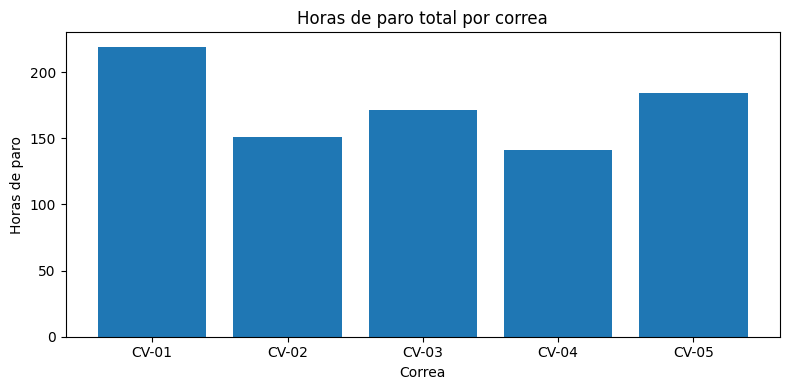

In [22]:
# 5.1 Horas de paro por correa

plt.figure(figsize=(8, 4))
plt.bar(kpi_correa["correa"], kpi_correa["horas_paro"])
plt.xlabel("Correa")
plt.ylabel("Horas de paro")
plt.title("Horas de paro total por correa")
plt.tight_layout()

plt.savefig("../img/horas_paro_por_correa.png", dpi=150)
plt.show()


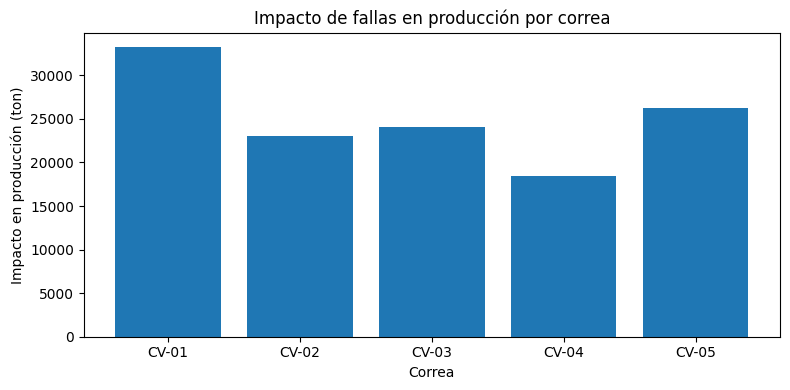

In [23]:
# 5.2 Impacto en producción por correa

plt.figure(figsize=(8, 4))
plt.bar(kpi_correa["correa"], kpi_correa["impacto_produccion_ton"])
plt.xlabel("Correa")
plt.ylabel("Impacto en producción (ton)")
plt.title("Impacto de fallas en producción por correa")
plt.tight_layout()

plt.savefig("../img/impacto_produccion_por_correa.png", dpi=150)
plt.show()


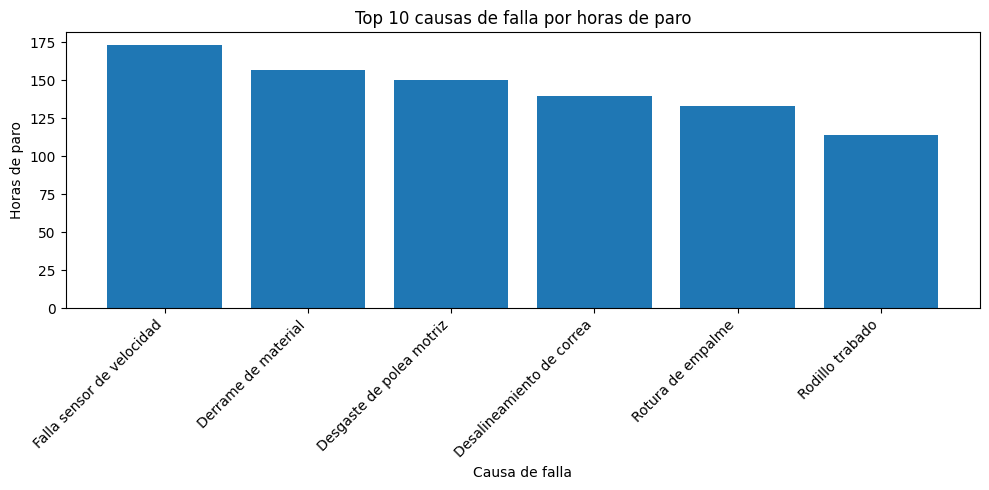

In [24]:
# 5.3 Top causas de falla

top_n = 10
top_causas = pareto_causas.head(top_n)

plt.figure(figsize=(10, 5))
plt.bar(top_causas["causa_falla"], top_causas["horas_paro"])
plt.xlabel("Causa de falla")
plt.ylabel("Horas de paro")
plt.title(f"Top {top_n} causas de falla por horas de paro")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

plt.savefig("../img/top_causas_falla_correas.png", dpi=150)
plt.show()
